# Recommendation Systems Project

Mate Balogh

E28H7B

**Item** recommendations for **visitors** in an online store based on *implicit feedback* to provide better user experience and to boost sales.

## Setup

In [345]:
!pip install cornac adjustText --quiet

In [346]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cornac
import itertools
import seaborn as sns

from cornac.eval_methods import RatioSplit
from cornac.metrics import Precision, Recall
from cornac.models import WMF
from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity

In [347]:
RAND = 10

In [348]:
#@title ### Helpers
def get_idx(ids, collection):
    return list(map(lambda x: collection.index.get_loc(x), ids))

In [349]:
#@title ### Download dataset
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ecommerce-dataset


## Dataset

In [350]:
events = pd.read_csv(path + "/events.csv",
                     dtype={'timestamp': int, 'visitorid': int, 'itemid': int, 'event': 'string', 'transactionid': object})

## Exploratory Data Analysis

In [351]:
events.shape

(2756101, 5)

In [352]:
events.columns.to_list()

['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

In [353]:
events.head(n=3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [354]:
events.isna().any()

,0
timestamp,False
visitorid,False
event,False
itemid,False
transactionid,True


In [355]:
events.describe()

,timestamp,visitorid,itemid
count,2.756101e+06,2.756101e+06,2.756101e+06
mean,1.436424e+12,7.019229e+05,2.349225e+05
std,3.366312e+09,4.056875e+05,1.341954e+05
min,1.430622e+12,0.000000e+00,3.000000e+00
25%,1.433478e+12,3.505660e+05,1.181200e+05
50%,1.436453e+12,7.020600e+05,2.360670e+05
75%,1.439225e+12,1.053437e+06,3.507150e+05
max,1.442545e+12,1.407579e+06,4.668670e+05


In [356]:
print("# of visitors in 'events':", events['visitorid'].count(), "among which", events['visitorid'].nunique(), "is unique.")
print("# of items in 'events':", events['itemid'].count(), "among which", events['itemid'].nunique(), "is unique.")
print("# of event in 'events':", events['event'].count(), "among which", events['event'].nunique(), "is unique.")
print("# of transactions in 'events':", events['transactionid'].count(), "among which", events['transactionid'].nunique(), "is unique.")

# of visitors in 'events': 2756101 among which 1407580 is unique.
# of items in 'events': 2756101 among which 235061 is unique.
# of event in 'events': 2756101 among which 3 is unique.
# of transactions in 'events': 22457 among which 17672 is unique.


In [357]:
events.sort_values(by=['transactionid'], ascending=False)

,timestamp,visitorid,event,itemid,transactionid
1113712,1440787093666,1283849,transaction,459615,9999
2372854,1437093851492,530559,transaction,357519,9998
1772020,1431999053822,55389,transaction,412516,9997
1478628,1430669157237,1390702,transaction,86218,9996
2090520,1435854317206,271719,transaction,238386,9995
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


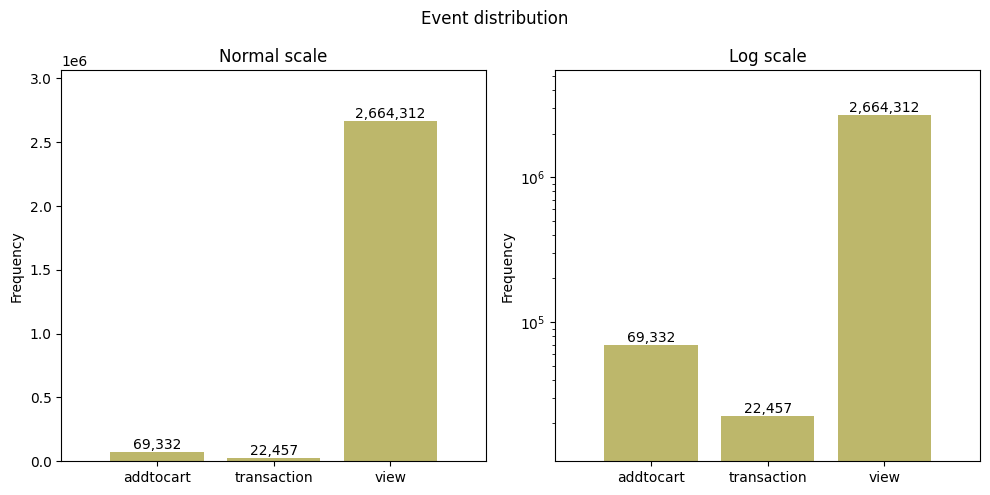

In [358]:
#@title #### Event frequency distribution

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

events_freqdist = events.groupby('event')['event'].count()

def plot_on_ax(_ax):
    fd = _ax.bar(events_freqdist.index, events_freqdist.values, color="darkkhaki")
    _ax.bar_label(fd, fmt="{:,.0f}")

ax = axes[0]
plot_on_ax(ax)
ax.set_title("Normal scale")

ax = axes[1]
plot_on_ax(ax)
ax.set_yscale('log')
ax.set_title("Log scale")

for ax in axes:
    ax.set_ylabel('Frequency')
    ax.margins(.15)

plt.suptitle('Event distribution')
plt.tight_layout()
plt.show()

del plot_on_ax

### Transaction events

In [359]:
condTransaction = events['event'] == 'transaction'
transaction_events = events[condTransaction]

print("`transaction_events` shape:", transaction_events.shape)
assert transaction_events['transactionid'].notna().all()

`transaction_events` shape: (22457, 5)


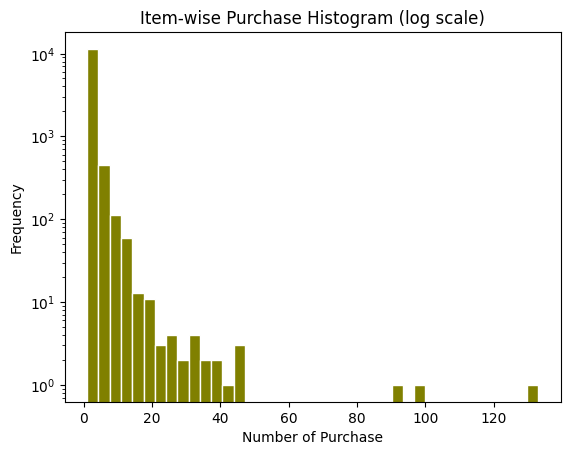

In [360]:
plt.hist(transaction_events.groupby(by='itemid')['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("Item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

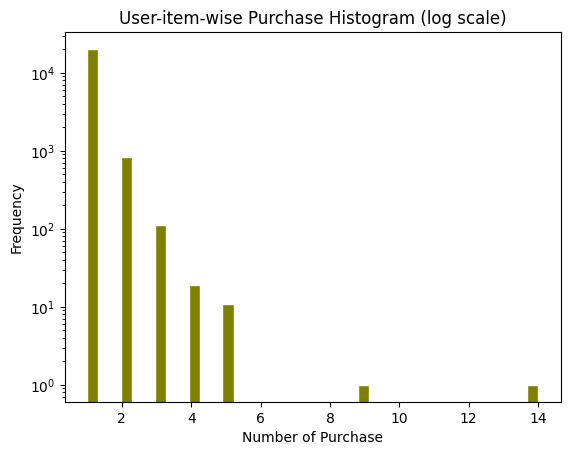

In [361]:
plt.hist(transaction_events.groupby(by=['visitorid', 'itemid'])['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("User-item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# Implementations

In [362]:
# designated user
designated_visitor_id = 71586
condDesignatedVisitor = transaction_events['visitorid'] == designated_visitor_id
assert transaction_events[condDesignatedVisitor]['itemid'].count() > 0

In [363]:
K = 100
N = 5

## `PopularItemRecommender`

In [364]:
class PopularItemRecommender():
    def __init__(self, transactions, verb=False):
        self.transactions = transactions
        self.verb = verb

        if self.verb:
            self.welcome()

    def welcome(self):
        print("Popular Item Recommender", "\n")

    def recommend(self, n):
        items_recommended = (
            self.transactions.groupby(by='itemid')['transactionid']
            .count()
            .sort_values(ascending=False)[:n]
            .index
            .tolist()
        )

        if self.verb:
            print("Recommended items:", "\n")
            display(pd.Series(items_recommended, name="itemid").to_frame().T)

        return items_recommended

In [365]:
items_recommended = (
    PopularItemRecommender(transaction_events, verb=True)
        .recommend(N)
)

Popular Item Recommender 

Recommended items: 



,0,1,2,3,4
itemid,461686,119736,213834,7943,312728


### Explanation

In [366]:
# designated user
display((designated_visitor_id, visitor_item_pivot.index.get_loc(designated_visitor_id)))

(71586, 575)

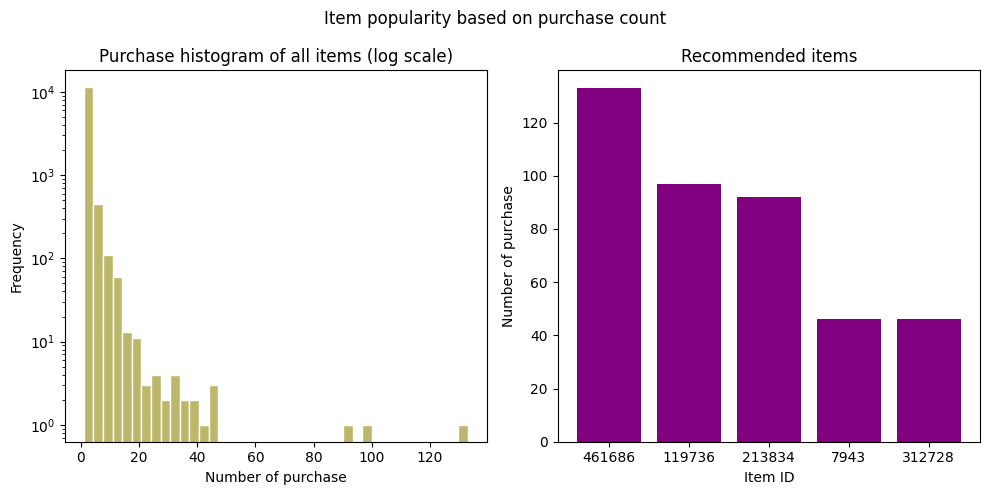

In [367]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 0
ax = axes[0]
df = transaction_events.groupby(by='itemid')['transactionid'].count()
ax.hist(df, bins=40, edgecolor="white", color="darkkhaki")

ax.set_title("Purchase histogram of all items (log scale)")
ax.set_xlabel("Number of purchase")
ax.set_ylabel("Frequency")
ax.set_yscale('log')

# 1
ax = axes[1]
df = (transaction_events
    .pipe(lambda df: df[df['itemid'].isin(items_recommended)])
    .pipe(lambda df: df.groupby(by='itemid')['transactionid'].count())
    .rename('purchase count')
    .sort_values(ascending=False)
    .reset_index()
)

ax.bar(df['itemid'].astype(str), df['purchase count'], color="purple")

ax.set_xlabel("Item ID")
ax.set_ylabel("Number of purchase")
ax.set_title("Recommended items")

plt.suptitle('Item popularity based on purchase count')
plt.tight_layout()
plt.show()

## `MeanPopularItemRecommender`

In [368]:
class MeanPopularItemRecommender():
    def __init__(self, transactions, verb=False):
        self.transactions = transactions
        self.verb = verb

        if self.verb:
            self.welcome()

    def welcome(self):
        print("Mean Popular Item Recommender", "\n")

    def recommend(self, n):
        items_recommended = (
            self.transactions
            .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
            .reset_index()
            .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean())
            .sort_values(ascending=False)[:n]
            .index
            .tolist()
        )

        if self.verb:
            print("Recommended items:", "\n")
            display(pd.Series(items_recommended, name="itemid").to_frame().T)

        return items_recommended

In [369]:
items_recommended = (
    MeanPopularItemRecommender(transaction_events, verb=True)
        .recommend(N)
)

Mean Popular Item Recommender 

Recommended items: 



,0,1,2,3,4
itemid,396042,224549,147,218612,347641


### Explanation

In [370]:
# designated user
display((designated_visitor_id, visitor_item_pivot.index.get_loc(designated_visitor_id)))

(71586, 575)

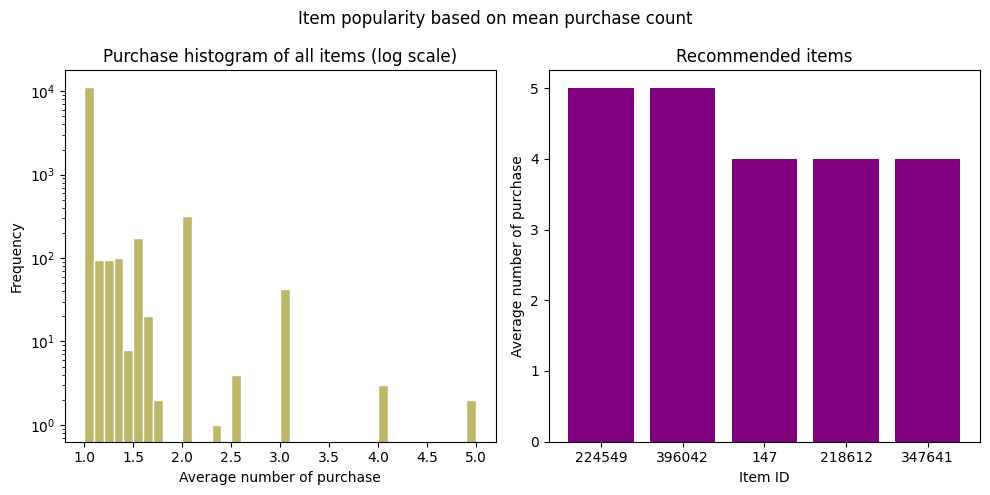

In [371]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 0
ax = axes[0]
df = (transaction_events
    .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
    .reset_index()
    .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean()))
ax.hist(df, bins=40, edgecolor="white", color="darkkhaki")

ax.set_title("Purchase histogram of all items (log scale)")
ax.set_xlabel("Average number of purchase")
ax.set_ylabel("Frequency")
ax.set_yscale('log')

# 1
ax = axes[1]
df = (transaction_events
    .pipe(lambda df: df[df['itemid'].isin(items_recommended)])
    .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
    .reset_index()
    .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean())
    .rename('mean purchase count')
    .sort_values(ascending=False)
    .reset_index()
)

ax.bar(df['itemid'].astype(str), df['mean purchase count'], color="purple")

ax.set_xlabel("Item ID")
ax.set_ylabel("Average number of purchase")
ax.set_title("Recommended items")

plt.suptitle('Item popularity based on mean purchase count')
plt.tight_layout()
plt.show()

## `UserBasedCollabFilterItemRecommender`

In [372]:
visitor_item_pivot = transaction_events.pivot_table(index='visitorid', columns='itemid', values='event', aggfunc='any').fillna(0).astype(int)
visitor_item_pivot
assert visitor_item_pivot.sum().sum() == transaction_events.groupby(by=['visitorid', 'itemid'])['itemid'].count().reset_index(drop=True).count()

In [373]:
visitor_item_similarity = cosine_similarity(visitor_item_pivot)
visitor_item_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [374]:
(visitor_item_pivot.shape, visitor_item_similarity.shape)

((11719, 12025), (11719, 11719))

In [375]:
visitor_loc = visitor_item_pivot.index.get_loc(designated_visitor_id)
selected_visitor_pivot = visitor_item_pivot.iloc[visitor_loc, :]
selected_visitor_similarity = visitor_item_similarity[visitor_loc, :]

In [376]:
class UserBasedCollabFilterItemRecommender():
    def __init__(self, pivot, similarity, verb=False):
        self.pivot = pivot
        self.similarity = similarity
        self.verb = verb

        self.fitted = False
        self.recommended = False

        if verb:
            self.welcome()

    def welcome(self):
        print("User-based Collaborative Filter Item Recommender")

    def fit(self, userid):
        self.userid = userid
        self.user_loc = self.pivot.index.get_loc(self.userid)
        self.user_pivot = self.pivot.iloc[self.user_loc, :]
        self.user_similarity = self.similarity[self.user_loc, :]

        interacted_mask = self.user_pivot[self.user_pivot.gt(0)]
        interacted_itemids = interacted_mask.index

        if self.verb:
           print("Item # already interacted with:\n\n", interacted_itemids.to_list(), "\n\n")

        self.interacted_itemids = interacted_itemids
        self.fitted = True

        return self

    def recommend(self, k, n, sim_threshold):
        self.k = k
        self.n = n

        similar_user_locs = self.user_similarity.argpartition(-(k+1))[-(k+1):]
        similar_user_locs = similar_user_locs[similar_user_locs != self.user_loc]
        similar_user_locs = similar_user_locs[self.user_similarity[similar_user_locs] >= sim_threshold]

        similar_userids = self.pivot.iloc[similar_user_locs].index

        if self.verb:
           print(f"K={self.k} most similar user (similarity threshold: {sim_threshold}) #:\n\n", similar_userids.to_list(), "\n\n")

        items_recommended = (self.pivot.iloc[similar_user_locs]
                                           .sum(axis=0)
                                           .astype('int')
                                           .rename('Transaction frequency')
                                           .where(lambda x: x > 0)
                                           .where(lambda x: np.invert(np.isin(x.index, self.interacted_itemids)))
                                           .dropna()
                                           .sort_values(ascending=False)[:self.n]
                                           .astype('int')
                            )

        self.similar_userids = similar_userids
        self.items_recommended = items_recommended
        self.recommended = True

        if self.verb:
            print("Recommended items:", "\n")
            display(pd.Series(items_recommended.index.tolist(), name="itemid").to_frame().T)

        return items_recommended

    def get_fit_memory(self):
        assert self.fitted, "Model not fitted. Call .fit() first."
        assert self.interacted_itemids is not None
        return {
            'userid': self.userid,
            'interacted_itemids': self.interacted_itemids.to_list()
        }

    def get_recommend_memory(self):
        assert self.recommended, "Model has no recommendation memory. Call .recommend() first."
        assert self.similar_userids is not None
        assert self.items_recommended is not None
        return {
            'similar_userids': self.similar_userids.to_list(),
            'items_recommended': self.items_recommended.index.to_list(),
            'k': self.k,
            'n': self.n
        }

In [377]:
model = UserBasedCollabFilterItemRecommender(visitor_item_pivot, visitor_item_similarity, verb=True)
model.fit(designated_visitor_id)

recommendation = model.recommend(K, N, sim_threshold=0.1)

User-based Collaborative Filter Item Recommender
Item # already interacted with:

 [461686] 


K=100 most similar user (similarity threshold: 0.1) #:

 [203490, 6952, 642130, 393237, 1353976, 250146, 349713, 264716, 747630, 1308333, 780392, 1336747, 292344, 939792, 1209995, 466691, 203017, 377978, 704586, 281553, 191477, 1286355, 404036, 502408, 807851, 288932, 967783, 1213114, 711110, 1029755, 303083, 609009, 796470, 110412, 880465, 648048, 602886, 483336, 1052508, 890458, 94182, 189934, 1165239, 187536, 1403350, 672896, 212610, 745620, 1374225, 677623, 830370, 747952, 562286, 832580, 1259098, 1170264, 674240, 673950, 470176, 396040, 222425, 1363526, 837781, 568495, 655336, 769006, 312771, 1183412, 1358883, 133632, 1009438, 488462, 871971, 351661, 880840, 724900, 980166, 628857, 1217315, 1215681, 1323498, 697366, 1073168, 1132549, 1041389, 603999, 261643, 550337, 1328538, 281703, 552261, 514028, 466364, 209317, 741178, 510429, 385715, 684072, 1251841, 72373] 


Recommended items: 



,0,1,2,3,4
itemid,10572,171878,218794,40630,32581


### Explanation

In [378]:
# designated user
display((designated_visitor_id, visitor_item_pivot.index.get_loc(designated_visitor_id)))

(71586, 575)

In [379]:
class UserBasedCFRVerifier():
    def __init__(self, model):
        self.model = model

    def run(self, designated_visitor_id):
        fm = self.model.get_fit_memory()
        rm = self.model.get_recommend_memory()

        # designater user
        assert designated_visitor_id == fm['userid']
        # interacted items
        df = transaction_events[transaction_events['visitorid'] == designated_visitor_id]
        assert (df['itemid'].nunique() == len(fm['interacted_itemids']))
        # similar users
        assert len(rm['similar_userids']) <= rm['k']
        assert np.invert(np.isin(designated_visitor_id, rm['similar_userids']))
        # recommended items
        assert np.invert(np.isin(fm['interacted_itemids'], rm['items_recommended'])).all()
        assert len(rm['items_recommended']) <= rm['n']

In [380]:
UserBasedCFRVerifier(model).run(designated_visitor_id)

In [381]:
fit_memory = model.get_fit_memory()
recommend_memory = model.get_recommend_memory()

In [382]:
# interacted items
print("Interacted itemids (acc. to model): ", fit_memory['interacted_itemids'])
print("Transaction records (history):")
display(transaction_events[condDesignatedVisitor])

Interacted itemids (acc. to model):  [461686]
Transaction records (history):


,timestamp,visitorid,event,itemid,transactionid
1283508,1441649735828,71586,transaction,461686,2695


In [383]:
# similar users
print(f"{recommend_memory['k']} similar user ids (acc. to model):\n", recommend_memory['similar_userids'])

# recommended items
print(f"{recommend_memory['n']} recommended item ids (acc. to model):\n", recommend_memory['items_recommended'])

100 similar user ids (acc. to model):
 [203490, 6952, 642130, 393237, 1353976, 250146, 349713, 264716, 747630, 1308333, 780392, 1336747, 292344, 939792, 1209995, 466691, 203017, 377978, 704586, 281553, 191477, 1286355, 404036, 502408, 807851, 288932, 967783, 1213114, 711110, 1029755, 303083, 609009, 796470, 110412, 880465, 648048, 602886, 483336, 1052508, 890458, 94182, 189934, 1165239, 187536, 1403350, 672896, 212610, 745620, 1374225, 677623, 830370, 747952, 562286, 832580, 1259098, 1170264, 674240, 673950, 470176, 396040, 222425, 1363526, 837781, 568495, 655336, 769006, 312771, 1183412, 1358883, 133632, 1009438, 488462, 871971, 351661, 880840, 724900, 980166, 628857, 1217315, 1215681, 1323498, 697366, 1073168, 1132549, 1041389, 603999, 261643, 550337, 1328538, 281703, 552261, 514028, 466364, 209317, 741178, 510429, 385715, 684072, 1251841, 72373]
5 recommended item ids (acc. to model):
 [10572, 171878, 218794, 40630, 32581]


In [384]:
# similarity of selected users
visitor_item_similarity[
    get_idx([designated_visitor_id], visitor_item_pivot),
    get_idx(recommend_memory['similar_userids'], visitor_item_pivot)
]

array([0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [385]:
condSimilarUsers = transaction_events['visitorid'].isin(recommend_memory['similar_userids'])

df = (transaction_events[condSimilarUsers]
    .where(lambda x: x['itemid'].isin(recommend_memory['items_recommended']))
    .dropna()
    .sort_values(by=['itemid', 'visitorid']))

assert df['itemid'].nunique() == len(recommend_memory['items_recommended'])

display(df)

,timestamp,visitorid,event,itemid,transactionid
1390528,1.442189e+12,303083.0,transaction,10572.0,6628
1359605,1.442001e+12,349713.0,transaction,10572.0,3093
1325186,1.441864e+12,404036.0,transaction,10572.0,17622
728216,1.438972e+12,642130.0,transaction,10572.0,15543
898773,1.439843e+12,967783.0,transaction,10572.0,11803
655940,1.438658e+12,1336747.0,transaction,10572.0,15907
1325206,1.441863e+12,609009.0,transaction,32581.0,12919
79498,1.433440e+12,1213114.0,transaction,32581.0,6087
2365351,1.436901e+12,203490.0,transaction,40630.0,4136
2626412,1.437932e+12,483336.0,transaction,40630.0,6808


In [386]:
similar_visitor_ids = recommend_memory['similar_userids']

other_visitor_ids = (
    visitor_item_pivot
        .index
        .to_frame()
        .reset_index(drop=True)
        .where(lambda x: x != designated_visitor_id)
        .dropna()
)['visitorid'].tolist()

other_visitor_ids_not_in_similar_users = (visitor_item_pivot.loc[list(set(other_visitor_ids).difference(set(similar_visitor_ids)))]
                                            .index
                                            .tolist())

(len(visitor_item_pivot), len(similar_visitor_ids), len(other_visitor_ids), len(other_visitor_ids_not_in_similar_users))

(11719, 100, 11718, 11618)

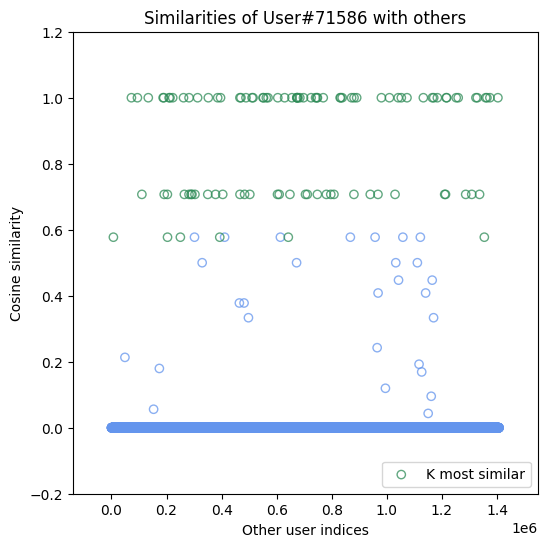

In [387]:
df = pd.DataFrame(visitor_item_similarity[
    get_idx([designated_visitor_id], visitor_item_pivot),
    get_idx(other_visitor_ids, visitor_item_pivot)
], columns=['similarity'], index=other_visitor_ids)

df['in_similar_users'] = visitor_item_pivot.loc[other_visitor_ids].index.isin(similar_visitor_ids)

plt.figure(figsize=(6, 6))
plt.scatter(other_visitor_ids_not_in_similar_users, df.loc[other_visitor_ids_not_in_similar_users]['similarity'], alpha=0.75, color="none", edgecolor="cornflowerblue")
plt.scatter(visitor_item_pivot.loc[similar_visitor_ids].index, df.loc[similar_visitor_ids]['similarity'], alpha=0.75, color="none", edgecolor="seagreen", label="K most similar")
plt.xlabel("Other user indices")
plt.ylabel("Cosine similarity")
plt.title(f"Similarities of User#{designated_visitor_id} with others")
plt.legend(loc="lower right")
plt.margins(0.1, 0.2)
plt.show()

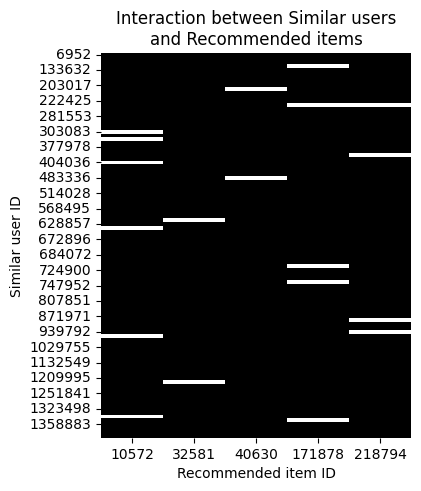

In [388]:
df = (transaction_events[condSimilarUsers]
    .where(lambda x: x['itemid'].isin(recommend_memory['items_recommended']))
    .dropna()
    .sort_values(by=['itemid', 'visitorid']))[['visitorid', 'itemid']]

df['interaction'] = np.ones(df.shape[0])

all_users = recommend_memory['similar_userids']
all_items = recommend_memory['items_recommended']

full_index = pd.MultiIndex.from_product([all_users, all_items], names=['visitorid', 'itemid'])
full_df = df.set_index(['visitorid', 'itemid']).reindex(full_index, fill_value=0).reset_index()
pivot = full_df.pivot(index='visitorid', columns='itemid', values='interaction')

plt.figure(figsize=(4, 5))
sns.heatmap(pivot, cmap='binary_r', cbar=False)
plt.title('Interaction between Similar users\nand Recommended items')
plt.xlabel('Recommended item ID')
plt.ylabel('Similar user ID')
plt.show()

## `MatrixFactorizationItemRecommender`

In [389]:
F = [2, 50]

In [390]:
class MatrixFactorizationItemRecommender():
    def __init__(self, verb=False):
        self.verb = verb
        self.wmf = None

        if self.verb:
            self.welcome()

    def welcome(self):
        print("Matrix Factorization (Weighted) Item Recommender", "\n")

    def experiment(self, ratio_split, metrics, k=2, max_iter=100, learning_rate=0.001):
        wmf = cornac.models.WMF(
            k=k,
            max_iter=max_iter,
            learning_rate=learning_rate,
            verbose=self.verb,
            seed=RAND
        )

        cornac.Experiment(eval_method=ratio_split, models=[wmf], metrics=metrics).run()
        self.wmf = wmf

### Explore suitability

In [391]:
display(transaction_events['visitorid'].nunique())
display(transaction_events['itemid'].nunique())

11719

12025

In [392]:
transaction_userwise = transaction_events.groupby(by=['visitorid'])
transaction_itemwise = transaction_events.groupby(by=['itemid'])

Unique item counts by users, implied by purchases 
 -----------------------------------------------
Min: 1
Max: 532
99th percentile: 11.0
Median: 1.0
Mean: 1.82


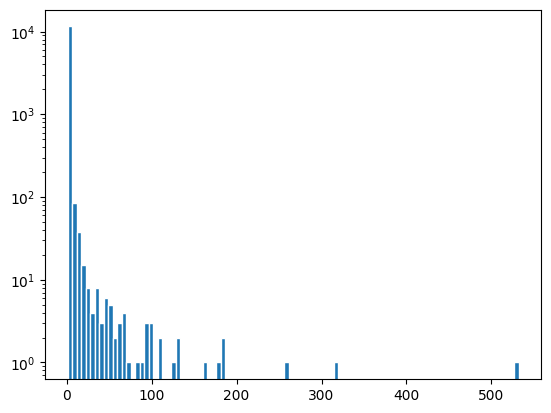

In [393]:
print("Unique item counts by users, implied by purchases", "\n", "-----------------------------------------------")
print("Min:", transaction_userwise['itemid'].nunique().min())
print("Max:", transaction_userwise['itemid'].nunique().max())
print("99th percentile:", np.percentile(transaction_userwise['itemid'].nunique(), 99))
print("Median:", np.round(transaction_userwise['itemid'].nunique().median(), 2))
print("Mean:", np.round(transaction_userwise['itemid'].nunique().mean(), 2))

plt.hist(transaction_userwise['itemid'].nunique(), bins=100, edgecolor="white")
plt.yscale("log")
plt.show()

### Preparation

In [394]:
class InteractionVisual():
    def __init__(self, df, value_key, split_name, binned=False):
        self.df = df
        self.value_key = value_key
        self.binned = binned
        self.split_name = split_name

    def plot(self):
        pv = self.df.pivot_table(index='visitorid', columns='itemid', values=self.value_key).fillna(0)

        if self.binned:
            bins = [-float('inf'), 0.5, 1.5, float('inf')]
            labels = [0, 1, 2]
            pv_binned = pd.cut(pv.values.flatten(), bins=bins, labels=labels, right=False)
            pv_binned = pv_binned.codes.reshape(pv.shape)
            pv = pv_binned

        plt.figure(figsize=(6, 5))
        plt.imshow(pv, cmap='magma', aspect='auto', interpolation='nearest')
        plt.colorbar()
        plt.xlabel('Items')
        plt.ylabel('Users')
        plt.title(f'Distinct user-item interactions {self.split_name} set')
        plt.show()

In [395]:
# filter only with enough interactions
keep_userids = transaction_userwise['itemid'].nunique().where(lambda x: x > 5).dropna().index
keep_itemids = transaction_itemwise['visitorid'].nunique().where(lambda x: x > 3).dropna().index

transaction_events_filtered = (transaction_events
                               .where(lambda x: x['visitorid'].isin(keep_userids))
                               .where(lambda x: x['itemid'].isin(keep_itemids))
                               .dropna())


display((len(keep_userids), len(keep_itemids)))
display((transaction_events_filtered['visitorid'].nunique(), transaction_events_filtered['itemid'].nunique()))

(249, 964)

(207, 798)

In [396]:
transaction_events_filtered

,timestamp,visitorid,event,itemid,transactionid
2981,1.433196e+12,273406.0,transaction,256146.0,8900
5222,1.433183e+12,286616.0,transaction,183087.0,8906
8637,1.433203e+12,404403.0,transaction,26210.0,15931
8987,1.433181e+12,138131.0,transaction,245168.0,6985
11455,1.433206e+12,1134975.0,transaction,303960.0,12383
...,...,...,...,...,...
2753537,1.438391e+12,861299.0,transaction,213834.0,4368
2753661,1.438374e+12,1150086.0,transaction,360825.0,9235
2753864,1.438375e+12,1150086.0,transaction,248455.0,16120
2754547,1.438381e+12,705542.0,transaction,546.0,13672


In [397]:
interaction_matrix = transaction_events_filtered[['visitorid', 'itemid']].copy()
interaction_matrix['1'] = 1
interaction_matrix.sort_values(by=['visitorid', 'itemid'])

,visitorid,itemid,1
898232,17676.0,546.0,1
970895,17676.0,869.0,1
879088,17676.0,63543.0,1
879082,17676.0,119267.0,1
977625,17676.0,158666.0,1
...,...,...,...
657544,1398978.0,38083.0,1
644561,1398978.0,330029.0,1
2246998,1403769.0,312728.0,1
2333660,1403769.0,312728.0,1


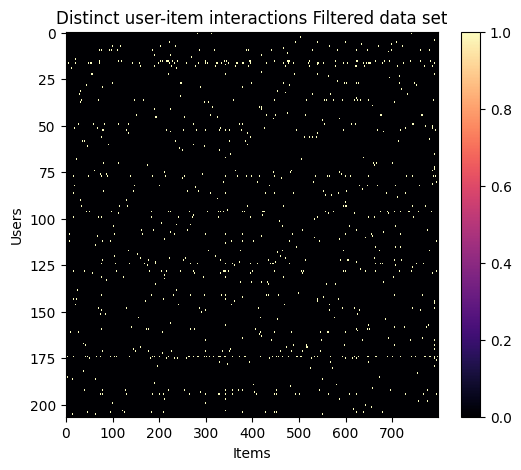

In [398]:
# filtered data to be splitted into train/test sets
InteractionVisual(interaction_matrix, value_key="1", split_name="Filtered data").plot()

In [399]:
ratio_split = RatioSplit(
    data=interaction_matrix.values,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=RAND,
    rating_threshold=0.5,
)

map_metric = cornac.metrics.MAP()
ndcg = cornac.metrics.NDCG()

rec_10 = cornac.metrics.Recall(k=10)
rec_50 = cornac.metrics.Recall(k=50)
rec_300 = cornac.metrics.Recall(k=300)
rec_all = cornac.metrics.Recall(k=-1)

prec_10 = cornac.metrics.Precision(k=10)
prec_50 = cornac.metrics.Precision(k=50)
prec_300 = cornac.metrics.Precision(k=300)
prec_all = cornac.metrics.Precision(k=-1)

metrics = [map_metric, ndcg, prec_50, rec_50]

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 198
Number of items = 729
Number of ratings = 1565
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 198
Number of items = 729
Number of ratings = 337
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 198
Total items = 729


/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:335: UserWarning: 156 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:335: UserWarning: 5 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [400]:
# retrieve train and test sets
train_userids = [id for id, idx in ratio_split.train_set.uid_map.items()]
train_itemids = [id for id, idx in ratio_split.train_set.iid_map.items()]

test_userids = [id for id, idx in ratio_split.test_set.uid_map.items()]
test_itemids = [id for id, idx in ratio_split.test_set.iid_map.items()]

display((len(train_userids), len(train_itemids)))
display((len(test_userids), len(test_itemids)))

(198, 729)

(198, 729)

In [401]:
model = MatrixFactorizationItemRecommender(verb=True)
model.experiment(ratio_split, metrics, k=F[0], max_iter=100, learning_rate=0.001)

Matrix Factorization (Weighted) Item Recommender 


[WMF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/109 [00:00<?, ?it/s]


TEST:
...
    |    MAP | NDCG@-1 | Precision@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------- + ------------ + --------- + --------- + --------
WMF | 0.0250 |  0.1889 |       0.0068 |    0.1050 |    1.6964 |   0.1474



In [402]:
uid_map_inv = {v: k for k, v in ratio_split.train_set.uid_map.items()}
iid_map_inv = {v: k for k, v in ratio_split.train_set.iid_map.items()}

train_uir = ratio_split.train_set.uir_tuple

train_interaction_matrix = pd.DataFrame({
    "visitorid": [uid_map_inv[uid] for uid in train_uir[0]],
    "itemid": [iid_map_inv[iid] for iid in train_uir[1]],
    "known_score": train_uir[2]
})

In [403]:
test_uir = ratio_split.test_set.uir_tuple

test_interaction_matrix = pd.DataFrame({
    "visitorid": [uid_map_inv[uid] for uid in test_uir[0]],
    "itemid": [iid_map_inv[iid] for iid in test_uir[1]],
    "known_score": test_uir[2]
})

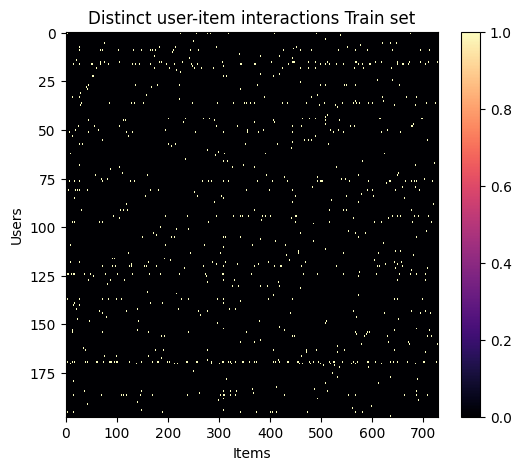

In [404]:
InteractionVisual(train_interaction_matrix, value_key="known_score", split_name="Train").plot()

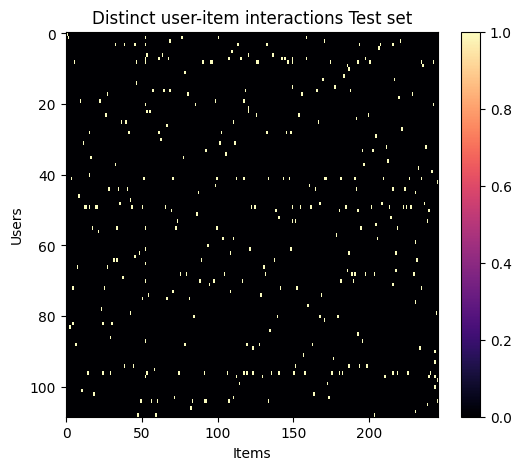

In [405]:
InteractionVisual(test_interaction_matrix, value_key="known_score", split_name="Test").plot()

In [406]:
rec = np.dot(model.wmf.U, model.wmf.V.T)
display(rec.shape)

(198, 729)

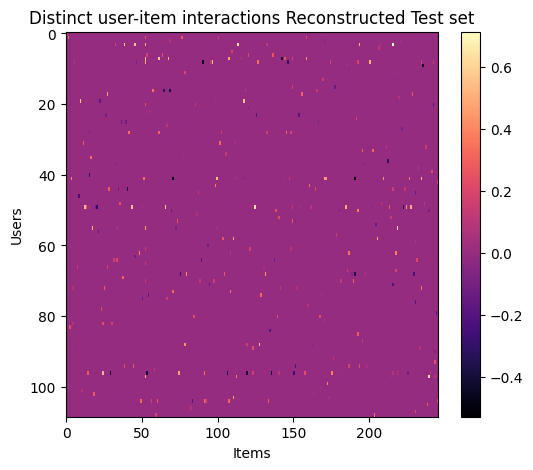

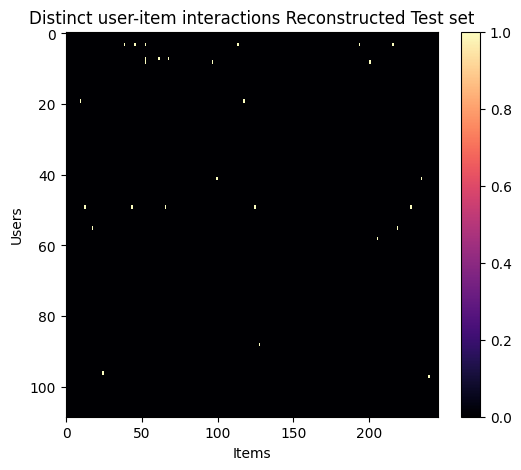

In [407]:
uids, iids, _ = ratio_split.test_set.uir_tuple

predicted_scores = rec[uids, iids]

predicted_interaction_matrix = pd.DataFrame({
    "visitorid": [uid_map_inv[uid] for uid in uids],
    "itemid": [iid_map_inv[iid] for iid in iids],
    "predicted_score": predicted_scores
})

InteractionVisual(predicted_interaction_matrix, value_key="predicted_score", split_name="Reconstructed Test", binned=False).plot()
InteractionVisual(predicted_interaction_matrix, value_key="predicted_score", split_name="Reconstructed Test", binned=True).plot()

<ipython-input-408-c877cbdc191f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax)


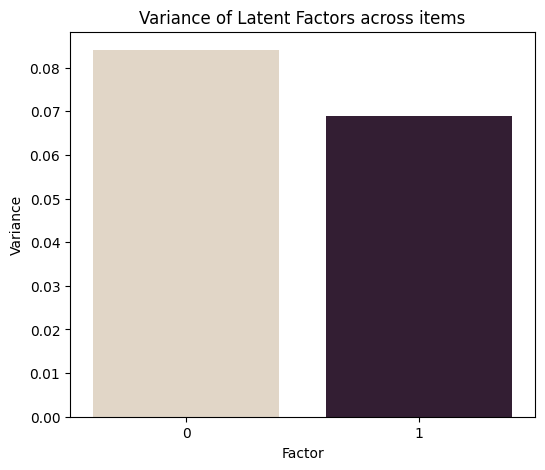

In [408]:
var_df = pd.DataFrame({"Factor": np.arange(F[0]), "Variance": np.var(model.wmf.V, axis=0)})
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax)
plt.title("Variance of Latent Factors across items")
plt.show()

<ipython-input-409-33ef9cea69c1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


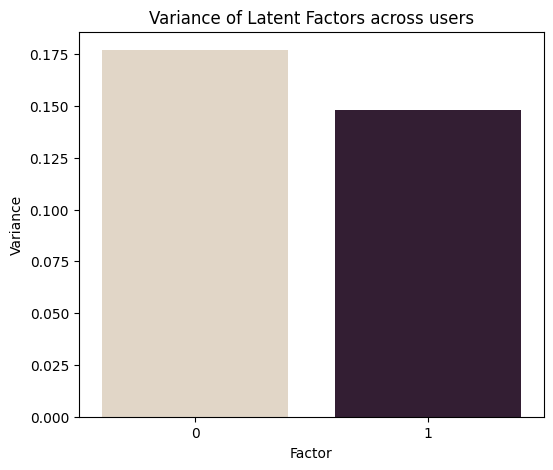

In [409]:
var_df = pd.DataFrame({"Factor": np.arange(F[0]), "Variance": np.var(model.wmf.U, axis=0)})
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);
plt.title("Variance of Latent Factors across users")
plt.show()

In [410]:
pd.DataFrame(rec)

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
0,0.221451,-0.189082,-0.054203,-0.233508,0.272248,0.266665,-0.008583,0.038665,-0.132547,-0.041643,...,-0.089178,-0.277563,0.041747,0.218390,0.150875,-0.013456,0.225122,-0.189259,-0.139657,0.015583
1,-0.153542,0.166935,0.238527,0.160836,-0.190811,-0.170745,0.188204,-0.216616,0.269728,0.222762,...,0.152198,0.196310,0.168718,-0.117594,-0.135966,-0.118840,-0.136719,0.223216,0.037614,0.195755
2,0.026929,0.069134,0.510003,-0.031138,0.027841,0.068796,0.467494,-0.483258,0.441040,0.493389,...,0.221471,-0.023825,0.513229,0.113519,-0.062266,-0.331135,0.077171,0.213483,-0.169218,0.532921
3,-0.259533,0.250838,0.227490,0.272793,-0.320736,-0.300979,0.158773,-0.200192,0.300442,0.207012,...,0.178250,0.328446,0.112362,-0.228344,-0.202407,-0.088813,-0.248031,0.296869,0.115353,0.150284
4,0.336008,-0.261815,0.058388,-0.355050,0.411650,0.414514,0.114525,-0.074169,-0.076665,0.072507,...,-0.072069,-0.418446,0.201674,0.355038,0.206979,-0.110115,0.355135,-0.222784,-0.253344,0.168203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,-0.026501,0.048445,0.151258,0.027175,-0.034055,-0.021719,0.132332,-0.141374,0.143977,0.144671,...,0.075776,0.035997,0.137410,-0.001764,-0.040646,-0.090729,-0.012985,0.088925,-0.025951,0.146951
194,0.152893,-0.128951,-0.028481,-0.161266,0.187874,0.184740,0.002184,0.018249,-0.083600,-0.020123,...,-0.057549,-0.191463,0.037618,0.152286,0.102771,-0.014994,0.156291,-0.126575,-0.099057,0.019951
195,0.083320,-0.077611,-0.056672,-0.087665,0.102802,0.097778,-0.036133,0.048815,-0.081975,-0.050672,...,-0.049868,-0.105130,-0.019978,0.076062,0.062427,0.018076,0.081205,-0.087817,-0.041855,-0.031428
196,0.083430,-0.072512,-0.027581,-0.087934,0.102640,0.099960,-0.009728,0.021330,-0.056273,-0.022598,...,-0.036817,-0.104707,0.008684,0.081071,0.057958,-0.000502,0.084123,-0.074580,-0.050504,-0.001490
